In [3]:
import base64
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import torch
from torch import distributions, nn
import torch.nn.functional as F
import time
import tqdm

# Custom imports
from vectorized_env import KaggleMABEnvTorchVectorized, END_OF_GAME, EVERY_STEP

%matplotlib inline
jtplot.style()

device = torch.device('cuda')

## Pytorch layer and model definitions

In [4]:
class FullyConnectedGNNLayer(nn.Module):
    def __init__(self, n_nodes, in_features, out_features, activation_func=nn.ReLU(), squeeze_out=False):
        super().__init__()
        self.n_nodes = n_nodes
        self.activation_func = activation_func
        self.transform_features = nn.Linear(in_features, out_features)
        self.message_passing_mat = nn.Parameter(
            (torch.ones((n_nodes, n_nodes)) - torch.eye(n_nodes)) / (n_nodes - 1),
            requires_grad=False
        )
        self.recombine_features = nn.Linear(out_features*2, out_features)
        self.squeeze_out = squeeze_out
        # Initialize linear layer weights
        nn.init.normal_(self.transform_features.weight, mean=0., std=0.2)
        nn.init.normal_(self.recombine_features.weight, mean=0., std=0.2)
        nn.init.constant_(self.transform_features.bias, 0.)
        nn.init.constant_(self.recombine_features.bias, 0.)
    
    def forward(self, features):
        features_transformed = self.activation_func(
            self.transform_features(features)
        )
        messages = torch.matmul(self.message_passing_mat, features_transformed)
        features_messages_combined = self.activation_func(
            self.recombine_features(torch.cat([features_transformed, messages], dim=-1))
        )
        if self.squeeze_out:
            return features_messages_combined.squeeze(dim=-1)
        else:
            return features_messages_combined
        

class GraphNN_A3C(nn.Module):
    def __init__(self, in_features, n_nodes, n_hidden_layers, layer_sizes,
                 activation_func = nn.ReLU()):
        super().__init__()
        
        # Define network
        if type(layer_sizes) == int:
            layer_sizes = [layer_sizes] * (n_hidden_layers + 1)
        assert len(layer_sizes) == n_hidden_layers + 1, f'len(layer_sizes) must equal n_hidden_layers + 1, was {len(layer_sizes)} but should have been {n_hidden_layers+1}'
        layers = [FullyConnectedGNNLayer(n_nodes, in_features, layer_sizes[0], activation_func=activation_func)]
        for i in range(n_hidden_layers):
            layers.append(FullyConnectedGNNLayer(n_nodes, layer_sizes[i], layer_sizes[i+1], activation_func=activation_func))
            
        self.base = nn.Sequential(*layers)
        self.actor = FullyConnectedGNNLayer(n_nodes, layer_sizes[-1], 1, activation_func=activation_func, squeeze_out=True)
        self.critic = FullyConnectedGNNLayer(n_nodes, layer_sizes[-1], 1, activation_func=nn.Identity(), squeeze_out=True)
    
    def forward(self, states):
        base_out = self.base(states)
        return self.actor(base_out), self.critic(base_out).mean(dim=-1)
    
    def sample_action(self, states):
        with torch.no_grad():
            logits, _ = self.forward(states)
            probs = F.softmax(logits, dim=-1)
            batch_size, n_envs, n_players, n_bandits = probs.shape
            m = torch.distributions.Categorical(probs.view(batch_size * n_envs * n_players, n_bandits))
            return m.sample().view(batch_size, n_envs, n_players)
    
    def choose_best_action(self, states):
        with torch.no_grad():
            logits, _ = self.forward(states)
            return logits.argmax(dim=-1)
    
    def loss_func(self, states, actions, v_t):
        #print(f'states.shape: {states.shape}, actions.shape: {actions.shape}, v_t.shape: {v_t.shape}')
        logits, values = self.forward(states)
        
        #print(f'logits.shape: {logits.shape}, values.shape: {values.shape}')
        td = v_t - values
        critic_loss = td.pow(2).view(-1)
        
        probs = F.softmax(logits, dim=-1)
        batch_size, n_envs, n_players, n_bandits = probs.shape
        m = torch.distributions.Categorical(probs.view(batch_size * n_envs * n_players, n_bandits))
        #print(f'm.log_prob(actions.view(batch_size * n_envs * n_players)).shape: {m.log_prob(actions.view(batch_size * n_envs * n_players)).shape}, td.shape: {td.shape}')
        actor_loss = -(m.log_prob(actions.view(-1)) * td.detach().view(-1))
        total_loss = (critic_loss + actor_loss).mean()
        return total_loss

## A3C RL algorithm

In [32]:
def a3c_vectorized_env(env, model, optimizer, n_episodes, batch_size,
                       gamma=0.9):
    model.to(device=device)
    model.train()
    episode_reward_sums = []
    
    for episode in tqdm.trange(n_episodes):
        buffer_s, buffer_a, buffer_r = [], [], []
        s, r, _, _ = env.reset()
        episode_reward_sums.append(r)
        step_count = 1
        while not env.done:
            # Batch size of 1 for inference
            a = model.sample_action(s.to(device=device).unsqueeze(0)).squeeze(0)
            next_s, r, done, _ = env.step(a)
            
            #print(s.shape, a.shape, r.shape)
            buffer_s.append(s)
            buffer_a.append(a)
            buffer_r.append(r)
            
            if step_count % batch_size == 0 or done:
                if done:
                    v_next_s = torch.zeros_like(buffer_r[-1])
                else:
                    _, v_next_s = model(next_s.to(device=device).unsqueeze(0))
                    v_next_s = v_next_s.detach().squeeze(0)
                v_next_s.to(device=device)
                
                buffer_v_target = []
                for r in buffer_r[::-1]:
                    v_next_s = r + gamma * v_next_s
                    buffer_v_target.append(v_next_s)
                buffer_v_target.reverse()
                
                loss = model.loss_func(
                    torch.stack(buffer_s).to(device=device),
                    torch.stack(buffer_a).to(device=device),
                    torch.stack(buffer_v_target).to(device=device)
                )
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                buffer_s, buffer_a, buffer_r = [], [], []
            s = next_s
            episode_reward_sums[-1] += r
            step_count += 1
        episode_reward_sums[-1] = episode_reward_sums[-1].mean()
        if len(episode_reward_sums) == 1 or episode_reward_sums[-1] > max(episode_reward_sums[:-1]):
            model_sd_checkpoint = model.state_dict()
    return model_sd_checkpoint, episode_reward_sums

## Optional: load a saved model state_dict from a serialized string file

In [4]:
with open('rl_agents/ss_a3c_agent_2_hidden_8.txt', 'r') as f:
    serialized_string = f.readline()[2:-1].encode()
state_dict_bytes = base64.b64decode(serialized_string)
loaded_state_dicts = pickle.loads(state_dict_bytes)

## RL training
#### TODO:
Adjust size of GNN - add more layers? To do this I may need to use a residual architecture

Implement new RL algorithm - AWAC, and use top team's logs as training data. See: https://www.kaggle.com/masatomatsui/santa-episode-scraper

Eventually, experiment with reward_type = END_OF_GAME

In [33]:
env = KaggleMABEnvTorchVectorized(n_envs=512, out_device=device)
graph_nn_kwargs = dict(
    in_features=3,
    n_nodes=env.n_bandits,
    n_hidden_layers=3,
    layer_sizes=16
)
model = GraphNN_A3C(**graph_nn_kwargs)
try:
    sd = loaded_state_dicts['model_state_dict']
    model.load_state_dict(sd)
    print('Successfully loaded saved model')
    del loaded_state_dicts
except NameError:
    pass
#model = FeedForwardNN_A3C(3 * env.n_bandits, env.n_bandits)
model.to(device=device)
optimizer = torch.optim.Adam(model.parameters())

rl_alg_kwargs = dict(
    batch_size=30,
    gamma=0.99
)

100%|██████████| 25/25 [06:14<00:00, 14.98s/it]


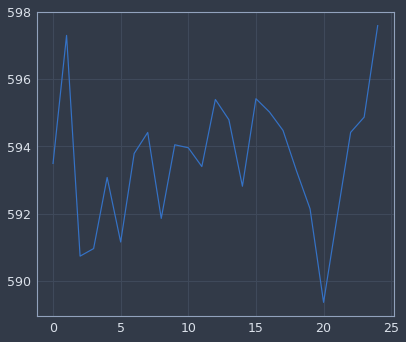

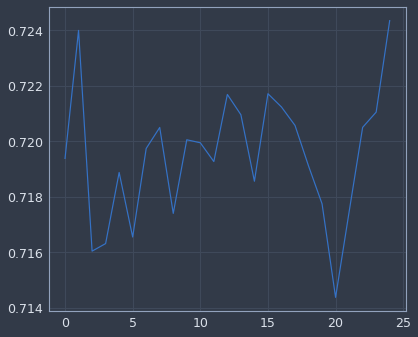

In [10]:
model_sd_checkpoint, episode_reward_sums = a3c_vectorized_env(env, model, optimizer, n_episodes=25, **rl_alg_kwargs)
plt.plot([rs / env.r_norm for rs in episode_reward_sums])
plt.show();
#plt.plot(episode_reward_sums);

100%|██████████| 10/10 [02:26<00:00, 14.69s/it]


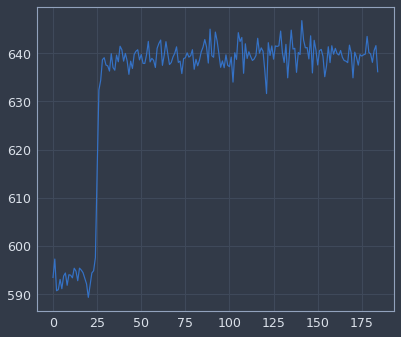

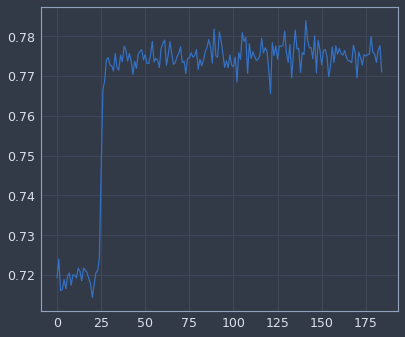

In [34]:
model_sd_checkpoint, ers = a3c_vectorized_env(env, model, optimizer, n_episodes=10, **rl_alg_kwargs)
episode_reward_sums += ers
plt.plot([rs / env.r_norm for rs in episode_reward_sums])
plt.show();
#plt.plot(episode_reward_sums);

## Benchmark the model against the checkpointed version

In [36]:
checkpointed_model = GraphNN_A3C(**graph_nn_kwargs)
checkpointed_model.to(torch.device('cuda'))
checkpointed_model.load_state_dict(model_sd_checkpoint)

def opponent(states):
    return checkpointed_model.sample_action(states.unsqueeze(0)).squeeze(0)

vs_env = KaggleMABEnvTorchVectorized(n_envs=512, opponent=opponent, out_device=device)
s, _, _, _ = vs_env.reset()
for i in tqdm.trange(vs_env.n_steps):
    s, _, _, _ = vs_env.step(model.sample_action(s.unsqueeze(0)).squeeze(0))
p1_scores, p2_scores = vs_env.player_rewards_sums.sum(-1).chunk(2, dim=1)
print(f'latest_model -vs- checkpointed_model')
print(f'Mean scores: {p1_scores.mean():.2f} - {p2_scores.mean():.2f}')
print(f'Match score: {torch.sum(p1_scores > p2_scores)} - {torch.sum(p1_scores == p2_scores)} - {torch.sum(p1_scores < p2_scores)}')

100%|██████████| 1999/1999 [00:06<00:00, 305.52it/s]

latest_model -vs- checkpointed_model
Mean scores: 640.90 - 639.32
Match score: 268 - 4 - 240


## Benchmark the model against a previous version

In [39]:
best_model = GraphNN_A3C(
    in_features=3,
    n_nodes=env.n_bandits,
    n_hidden_layers=3,
    layer_sizes=16
)
with open('rl_agents/ss_a3c_agent_v1.txt', 'r') as f:
    sd = pickle.loads(base64.b64decode(f.readline()[2:-1].encode()))['model_state_dict']
best_model.load_state_dict(sd)
best_model.to(torch.device('cuda'))

def opponent(states):
    return best_model.sample_action(states.unsqueeze(0)).squeeze(0)

vs_env = KaggleMABEnvTorchVectorized(n_envs=512, opponent=opponent, out_device=device)
s, _, _, _ = vs_env.reset()
for i in tqdm.trange(vs_env.n_steps):
    s, _, _, _ = vs_env.step(model.sample_action(s.unsqueeze(0)).squeeze(0))
p1_scores, p2_scores = vs_env.player_rewards_sums.sum(-1).chunk(2, dim=1)
print(f'new_model -vs- best_model')
print(f'Mean scores: {p1_scores.mean():.2f} - {p2_scores.mean():.2f}')
print(f'Match score: {torch.sum(p1_scores > p2_scores)} - {torch.sum(p1_scores == p2_scores)} - {torch.sum(p1_scores < p2_scores)}')

100%|██████████| 1999/1999 [00:06<00:00, 308.33it/s]

new_model -vs- best_model
Mean scores: 631.88 - 643.26
Match score: 177 - 8 - 327


## Benchmark the model against hand-crafted algorithms

In [16]:
# TODO: Rewrite Thompson sampling and pull_vegas_slot_machines for vectorized_env

## Visualize model parameter distributions

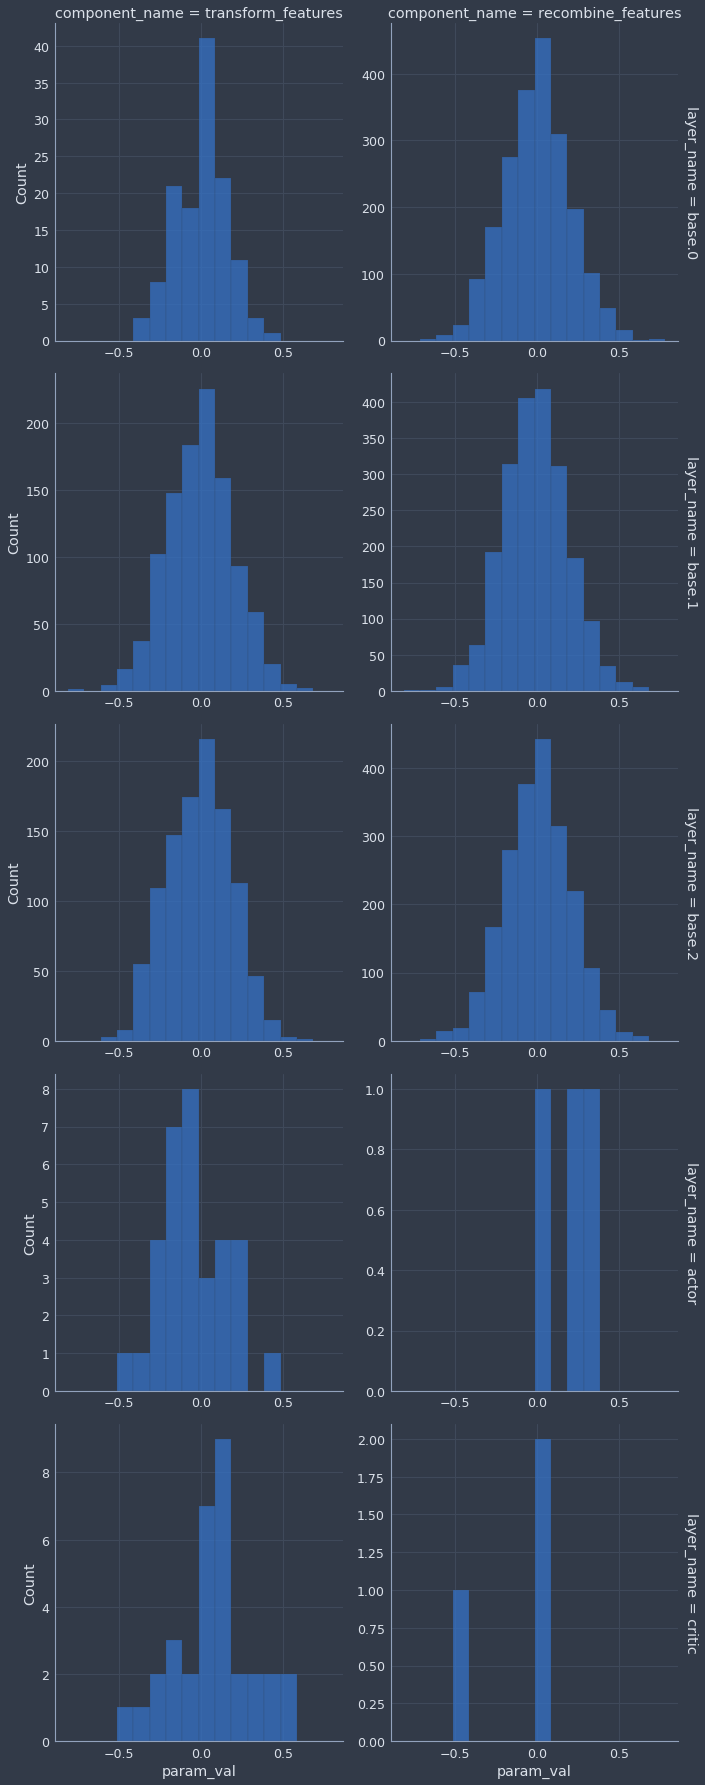

In [32]:
full_layer_name = []
layer_name = []
component_name = []
weight_or_bias = []
param_val = []
for key, val in GraphNN_A3C(
    in_features=3,
    n_nodes=env.n_bandits,
    n_hidden_layers=2,
    layer_sizes=32
).state_dict().items():
    if 'message_passing_mat' in key:
        pass
    else:
        for v in val.cpu().numpy().ravel():
            param_val.append(v)
            full_layer_name.append(key)
            key_split = key.split('.')
            if len(key_split) == 3:
                ln, pn, wob = key_split
            elif len(key_split) == 4:
                ln, ln_2, pn, wob = key_split
                ln = f'{ln}.{ln_2}'
            else:
                raise RuntimeError(f'Unrecognized layer key: {key}')
            layer_name.append(ln)
            component_name.append(pn)
            weight_or_bias.append(wob)
params_df = pd.DataFrame(dict(
    full_layer_name = full_layer_name,
    layer_name = layer_name,
    component_name = component_name,
    weight_or_bias = weight_or_bias,
    param_val = param_val
))

sns.displot(
    params_df, x='param_val', col='component_name', row='layer_name',
    binwidth=0.1,
    #height=3,
    facet_kws=dict(margin_titles=True, sharex=False, sharey=False)
);

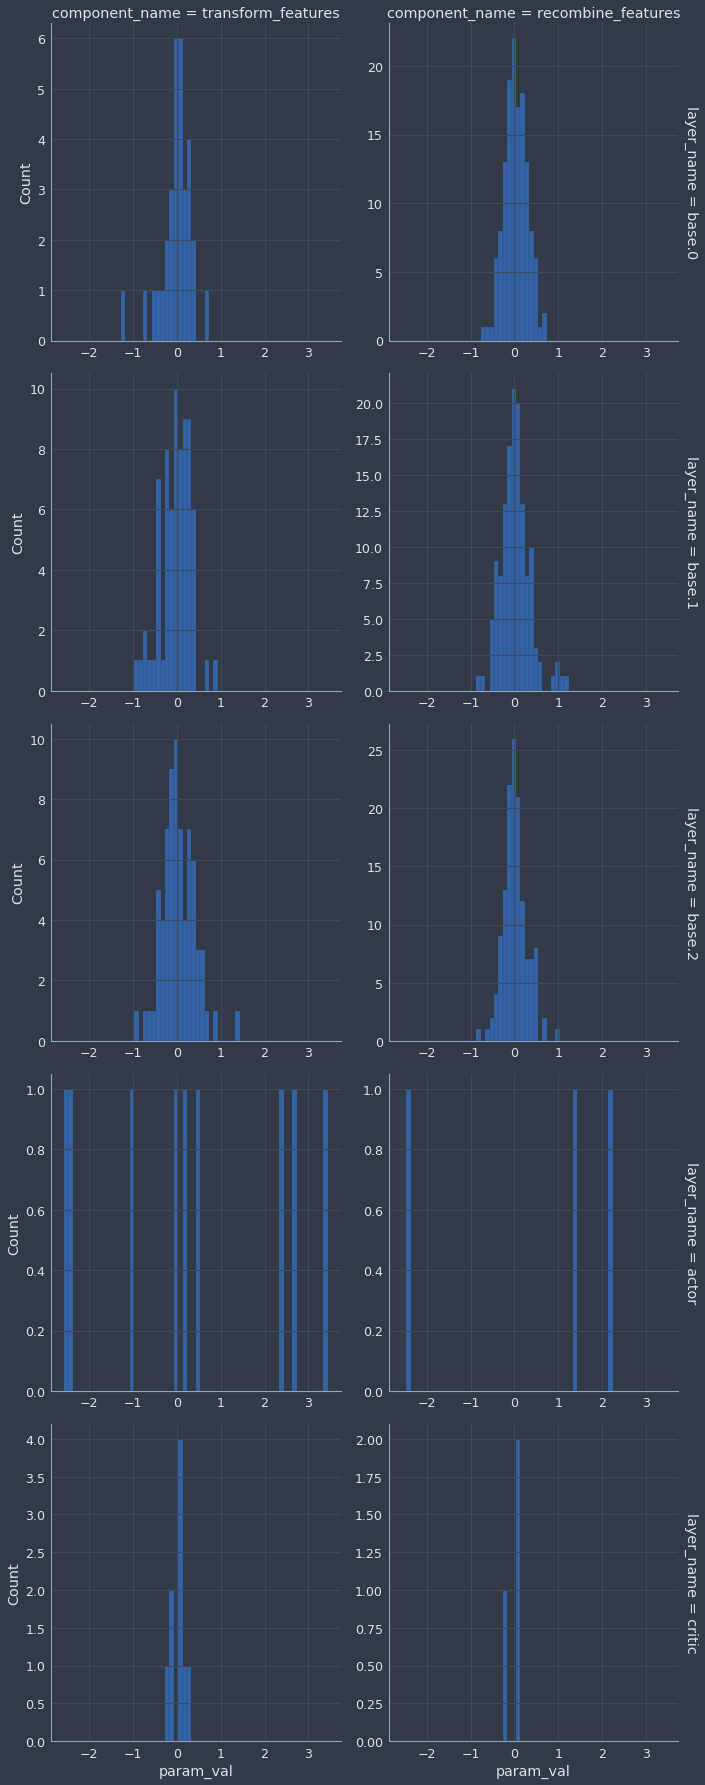

In [9]:
full_layer_name = []
layer_name = []
component_name = []
weight_or_bias = []
param_val = []
for key, val in model.state_dict().items():
    if 'message_passing_mat' in key:
        pass
    else:
        for v in val.cpu().numpy().ravel():
            param_val.append(v)
            full_layer_name.append(key)
            key_split = key.split('.')
            if len(key_split) == 3:
                ln, pn, wob = key_split
            elif len(key_split) == 4:
                ln, ln_2, pn, wob = key_split
                ln = f'{ln}.{ln_2}'
            else:
                raise RuntimeError(f'Unrecognized layer key: {key}')
            layer_name.append(ln)
            component_name.append(pn)
            weight_or_bias.append(wob)
params_df = pd.DataFrame(dict(
    full_layer_name = full_layer_name,
    layer_name = layer_name,
    component_name = component_name,
    weight_or_bias = weight_or_bias,
    param_val = param_val
))

sns.displot(
    params_df, x='param_val', col='component_name', row='layer_name',
    binwidth=0.1,
    #height=3,
    facet_kws=dict(margin_titles=True, sharex=False, sharey=False)
);

## Save the model state_dict as a serialized string

In [15]:
model.to('cpu')
state_dict_bytes = pickle.dumps({
    'model_state_dict': model.state_dict(),
    #'optimizer_state_dict': optimizer.state_dict()
})
serialized_string = base64.b64encode(state_dict_bytes)
with open('rl_agents/ss_temp.txt', 'w') as f:
    f.write(str(serialized_string))

## Testing and debugging

In [55]:
from scipy.stats import spearmanr, pearsonr

test_env = KaggleMABEnvTorchVectorized(n_players=2, decay_rate=0.97)
with torch.no_grad():
    test_env.reset()
    # Take n good actions
    for i in range(500):
        actions = test_env.thresholds.argmax(axis=-1)[:, None]
        s, _, _, _ = test_env.step(actions.repeat(1, test_env.n_players))
    logits, values = model(s[0,0].to(device=device)[None, None, :])
    logits = logits.cpu().numpy().squeeze()
    values = values.cpu().numpy().squeeze()
print()
print(logits)
print(values)
print(s[:,0].squeeze().t())
print(spearmanr(logits, test_env.thresholds.squeeze().cpu().numpy())[0],
      pearsonr(logits, test_env.thresholds.squeeze().cpu().numpy())[0])


[ 0.        0.       15.869064 15.869068  0.       15.869064  0.
 15.869062  0.       15.869066 13.328804 15.869064  0.       15.869064
  0.        0.        0.        0.        0.       15.869068  0.
 15.869064  0.        0.       15.869066  0.       15.584715  0.
  0.       15.869064 15.869062  0.        0.       15.869064  0.
 15.869068 15.869064 15.869064 13.328802  0.        0.        0.
  0.        0.        0.       15.869064 15.869062  0.        0.
 15.869064  0.       15.869068  0.        0.       15.869062  0.
  0.       15.869066 15.869064  0.       15.869064 15.869064 15.869062
  0.       15.869064 15.869064 15.869064  0.        0.        0.
 15.869062 15.869064 15.869066  0.        0.       15.869064  0.
 15.869064  0.       15.869066 15.869064  0.        0.        0.
  0.        0.       15.869062 15.869064  0.        0.        0.
  0.       14.832226 15.869064 15.869062  0.        0.        0.
 15.869064  0.      ]
0.063714825
tensor([[0.5503, 0.6503, 0.0000, 0.0000, 0.

In [11]:
child_layer_idx = -1
child_layer = list(model.children())[child_layer_idx]
print(child_layer.transform_features.weight.data, child_layer.transform_features.bias.data)
print(child_layer.recombine_features.weight.data, child_layer.recombine_features.bias.data)
print(model)
print(child_layer)

tensor([[ 0.0262,  0.1752, -0.0545,  0.1121, -0.1307, -0.2462,  0.0642,  0.1453,
          0.1664, -0.2003, -0.1945,  0.1583,  0.0691, -0.0952, -0.0247, -0.0223]],
       device='cuda:0') tensor([0.0936], device='cuda:0')
tensor([[-0.1309,  0.2959]], device='cuda:0') tensor([-0.0018], device='cuda:0')
GraphNN_A3C(
  (base): Sequential(
    (0): FullyConnectedGNNLayer(
      (activation_func): ReLU()
      (transform_features): Linear(in_features=3, out_features=16, bias=True)
      (recombine_features): Linear(in_features=32, out_features=16, bias=True)
    )
    (1): FullyConnectedGNNLayer(
      (activation_func): ReLU()
      (transform_features): Linear(in_features=16, out_features=16, bias=True)
      (recombine_features): Linear(in_features=32, out_features=16, bias=True)
    )
    (2): FullyConnectedGNNLayer(
      (activation_func): ReLU()
      (transform_features): Linear(in_features=16, out_features=16, bias=True)
      (recombine_features): Linear(in_features=32, out_featur

In [77]:
test_env = KaggleMABEnvTorchVectorized(n_envs=3, n_players=2, decay_rate=0.97, env_device=torch.device('cpu'), out_device=device)
test_env.reset()
actions = torch.arange(6).view(3,2)
test_env.step(actions)
test_env.step(actions)
actions = torch.arange(1,7).view(3,2)
test_env.step(actions)
test_env.step(actions)
test_env.step(actions)

test = test_env.player_n_pulls.unsqueeze(3).expand(-1,-1,-1,2).transpose(1,3)
test = torch.cat([
    test[:,0,:,:].unsqueeze(1),
    test[:,0,:,[1,0]].unsqueeze(1)
], dim=1)
test[0,0]
test_env.player_rewards_sums

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [59]:
# Simulated env rollouts with random policy
test_env = KaggleMABEnvTorchVectorized(n_envs=1000, n_players=2, decay_rate=0.97, env_device=torch.device('cuda'), out_device=torch.device('cuda'))

for i in tqdm.trange(test_env.n_steps):
    actions = torch.randint(test_env.n_bandits, size=(test_env.n_envs, test_env.n_players))
    test_env.step(actions)
print(f'Mean of player rewards: {test_env.player_rewards_sums.sum(axis=-1).mean():.2f}, Standard deviation of player rewards: {test_env.player_rewards_sums.sum(axis=-1).std():.2f}')

100%|██████████| 1999/1999 [00:01<00:00, 1477.49it/s]

Mean of player rewards: 590.30, Standard deviation of player rewards: 39.68


In [61]:
# Simulated env rollouts with omniscient optimal policy
test_env = KaggleMABEnvTorchVectorized(n_envs=1000, n_players=2, decay_rate=0.97, env_device=torch.device('cuda'), out_device=torch.device('cpu'))

for i in tqdm.trange(test_env.n_steps):
    actions = test_env.thresholds.argmax(axis=-1)[:, None]
    test_env.step(actions.repeat(1, test_env.n_players))
print(f'Mean of player rewards: {test_env.player_rewards_sums.sum(axis=-1).mean():.2f}, Standard deviation of player rewards: {test_env.player_rewards_sums.sum(axis=-1).std():.2f}')

100%|██████████| 1999/1999 [00:02<00:00, 997.25it/s] 

Mean of player rewards: 660.81, Standard deviation of player rewards: 39.56


In [152]:
n_nodes = 10
activation_func = nn.ReLU()
layer_size = 64
layers = (
    [FullyConnectedGNNLayer(n_nodes, 1, layer_size, activation_func=activation_func)] +
    [FullyConnectedGNNLayer(n_nodes, layer_size, layer_size, activation_func=activation_func)] * 0 +
    [FullyConnectedGNNLayer(n_nodes, layer_size, 1, activation_func=activation_func)]
)
model = nn.Sequential(
    *layers
)
#model = FullyConnectedGNNLayer(n_nodes, 1, 1, activation_func=nn.Identity())
model.train()
model.to('cuda')
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0002)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

for i in tqdm.trange(10):
    train_batch_in = torch.rand((250, n_nodes, 1), dtype=torch.float).to('cuda')
    k = 2
    labels = torch.topk(train_batch_in, k=k, dim=1).indices[:,k-1]
    
    optimizer.zero_grad()
    outputs = model(train_batch_in)
    loss = loss_func(outputs, labels)
    loss.backward()
    optimizer.step()
    
    accuracy = (F.softmax(outputs, dim=1).argmax(dim=1) == labels).float().mean()
print(f'Loss: {loss:.2f}, Accuracy: {accuracy:.3f}')

test_batch_in = torch.rand((1, n_nodes, 1), dtype=torch.float).to('cuda')
print(test_batch_in)
print(F.softmax(model(test_batch_in), dim=1))
print(torch.topk(test_batch_in, k=k, dim=1).indices[:,k-1])
print(F.softmax(model(test_batch_in), dim=1).argmax(dim=1))

100%|██████████| 10/10 [00:00<00:00, 479.15it/s]

Loss: 2.30, Accuracy: 0.000
tensor([[[0.8214],
         [0.5663],
         [0.7303],
         [0.6139],
         [0.0942],
         [0.2026],
         [0.8251],
         [0.3299],
         [0.0296],
         [0.5319]]], device='cuda:0')
tensor([[[0.1007],
         [0.1003],
         [0.1006],
         [0.1004],
         [0.0990],
         [0.0994],
         [0.1007],
         [0.0997],
         [0.0988],
         [0.1003]]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[0]], device='cuda:0')
tensor([[6]], device='cuda:0')


In [153]:
for i in tqdm.trange(1000):
    train_batch_in = torch.rand((250, n_nodes, 1), dtype=torch.float).to('cuda')
    k = 2
    labels = torch.topk(train_batch_in, k=k, dim=1).indices[:,k-1]
    
    optimizer.zero_grad()
    outputs = model(train_batch_in)
    loss = loss_func(outputs, labels)
    loss.backward()
    optimizer.step()
    
    accuracy = (F.softmax(outputs, dim=1).argmax(dim=1) == labels).float().mean()
print(f'Loss: {loss:.2f}, Accuracy: {accuracy:.3f}')

100%|██████████| 1000/1000 [00:01<00:00, 549.97it/s]

Loss: 2.29, Accuracy: 0.000


In [250]:
model = FullyConnectedGNNLayer(5, 1, 1, activation_func=nn.Identity())
model.train()
model.to('cuda')
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.)

for i in tqdm.trange(10000):
    train_batch_in = torch.rand((1024, 5, 1), dtype=torch.float).to('cuda')
    train_batch_out = train_batch_in + train_batch_in.sum(dim=1, keepdims=True)
    
    optimizer.zero_grad()
    outputs = model(train_batch_in)
    loss = loss_func(outputs, train_batch_out)
    loss.backward()
    optimizer.step()
loss

100%|██████████| 10000/10000 [00:08<00:00, 1172.83it/s]


tensor(2.2476e-11, device='cuda:0', grad_fn=<MseLossBackward>)

In [251]:
train_batch_in = torch.rand((2, 5, 1), dtype=torch.float).to('cuda')
print(train_batch_in)
print(train_batch_in + train_batch_in.sum(dim=1, keepdims=True))
print(model(train_batch_in))

tensor([[[0.8142],
         [0.2351],
         [0.0057],
         [0.8548],
         [0.5895]],

        [[0.9160],
         [0.7284],
         [0.4671],
         [0.4535],
         [0.1266]]], device='cuda:0')
tensor([[[3.3136],
         [2.7345],
         [2.5050],
         [3.3541],
         [3.0888]],

        [[3.6076],
         [3.4200],
         [3.1586],
         [3.1450],
         [2.8181]]], device='cuda:0')
tensor([[[3.3136],
         [2.7345],
         [2.5051],
         [3.3541],
         [3.0888]],

        [[3.6076],
         [3.4200],
         [3.1586],
         [3.1450],
         [2.8181]]], device='cuda:0', grad_fn=<AddBackward0>)


## Deprecated

In [ ]:
class Kaggle_MAB_Env_Numpy_Vectorized():
    def __init__(self,
                 # Kaggle MAB env params
                 n_bandits=100, n_steps=1999, decay_rate=0.97, sample_resolution=100,
                 # Custom params
                 n_envs=1, n_players=2, reward_type=EVERY_STEP, remove_extra_dims=False):
        # Assert parameter conditions
        assert 0 <= decay_rate <= 1.
        assert reward_type in (END_OF_GAME, EVERY_STEP)
        if reward_type == END_OF_GAME:
            assert n_players >= 2
        else:
            assert n_players >= 1
        self.n_bandits = n_bandits
        self.n_steps = n_steps
        self.decay_rate = decay_rate
        self.sample_resolution = sample_resolution
        
        self.n_envs = n_envs
        self.n_players = n_players
        self.reward_type = reward_type
        self.remove_extra_dims = remove_extra_dims
        
        self.timestep = None
        self.orig_thresholds = None
        self.player_n_pulls = None
        self.player_rewards_sums = None
        self.reset()
    
    @property
    def thresholds(self):
        return self.orig_thresholds * (self.decay_rate ** self.player_n_pulls[:,0,:])
    
    def reset(self):
        self.timestep = 0
        self.orig_thresholds = np.random.randint(self.sample_resolution + 1, size=(self.n_envs, self.n_bandits)).astype(np.float32)
        self.player_n_pulls = np.zeros((self.n_envs, self.n_players, self.n_bandits))
        self.player_rewards_sums = np.zeros_like(self.player_n_pulls)
        
        rewards = np.zeros((self.n_envs, self.n_players))
        if self.remove_extra_dims:
            return self.get_obs().squeeze(), rewards.squeeze(), self.done, dict(thresholds=self.thresholds.squeeze())
        else:
            return self.get_obs(), rewards, self.done, dict(thresholds=self.thresholds)
        
    def step(self, actions):
        if self.remove_extra_dims:
            if type(actions) == int:
                actions = np.array([[actions]])
            else:
                actions = actions.reshape((self.n_envs, self.n_players))
        assert actions.shape == (self.n_envs, self.n_players), f'actions.shape was: {actions.shape}'
        assert not self.done
        self.timestep += 1
        
        # Compute agent rewards
        selected_thresholds = np.take_along_axis(self.thresholds, actions, axis=1)
        pull_rewards = np.random.randint(self.sample_resolution, size=selected_thresholds.shape) < selected_thresholds
        #pull_rewards = selected_thresholds / float(self.sample_resolution)
        
        # Update player_n_pulls and player_rewards_sums
        for env_idx, env_actions in enumerate(actions):
            for player_idx, pull_idx in enumerate(env_actions):
                self.player_n_pulls[env_idx, :, pull_idx] += 1
                self.player_rewards_sums[env_idx, player_idx, pull_idx] += pull_rewards[env_idx, player_idx]
        
        # Return (obs, reward, done) tuple
        if self.reward_type == END_OF_GAME:
            rewards = np.zeros_like(actions)
            if self.timestep == self.n_steps:
                rewards_sums = self.player_rewards_sums.sum(axis=2)
                winners = rewards_sums.argmax(axis=1)
                rewards[winners] = 1
        elif self.reward_type == EVERY_STEP:
            rewards = pull_rewards
        
        # State, reward, done, info_dict
        if self.remove_extra_dims:
            return self.get_obs().squeeze(), rewards.squeeze(), self.done, dict(thresholds=self.thresholds.squeeze())
        else:
            return self.get_obs(), rewards, self.done, dict(thresholds=self.thresholds)
    
    def get_obs(self):
        # TODO: Clearly do not return thresholds or orig_thresholds
        return np.stack([
            #np.broadcast_to(self.orig_thresholds[:, None, :] / self.sample_resolution, self.player_n_pulls.shape),
            self.player_n_pulls,
            self.player_rewards_sums
        ], axis=-1).astype(np.float32)
    
    @property
    def done(self):
        return self.timestep >= self.n_steps

In [ ]:
class FeedForwardNN_A3C(nn.Module):
    def __init__(self, in_features, n_bandits, activation_func=nn.ReLU()):
        super().__init__()
        self.in_features = in_features
        self.activation_func = activation_func
        layer_size = 128
        self.base = nn.Sequential(
            nn.Linear(self.in_features, layer_size),
            activation_func,
            nn.Linear(layer_size, layer_size),
            activation_func,
        )
        self.actor = nn.Linear(layer_size, n_bandits)
        self.critic = nn.Linear(layer_size, 1)
        
    def forward(self, states):
        in_shape = states.shape
        base_out = self.base(states.view(-1, self.in_features))
        return self.activation_func(self.actor(base_out)).view(in_shape[:-1]), self.critic(base_out).view(in_shape[:-2])
    
    def sample_action(self, states):
        with torch.no_grad():
            logits, _ = self.forward(states)
            probs = F.softmax(logits, dim=-1)
            batch_size, n_envs, n_players, n_bandits = probs.shape
            m = torch.distributions.Categorical(probs.view(batch_size * n_envs * n_players, n_bandits))
            return m.sample().view(batch_size, n_envs, n_players)
    
    def choose_best_action(self, states):
        with torch.no_grad():
            logits, _ = self.forward(states)
            return logits.argmax(dim=-1)
        
    def loss_func(self, states, actions, v_t):
        #print(f'states.shape: {states.shape}, actions.shape: {actions.shape}, v_t.shape: {v_t.shape}')
        logits, values = self.forward(states)
        
        #print(f'logits.shape: {logits.shape}, values.shape: {values.shape}')
        td = v_t - values
        critic_loss = td.pow(2).view(-1)
        
        probs = F.softmax(logits, dim=-1)
        batch_size, n_envs, n_players, n_bandits = probs.shape
        m = torch.distributions.Categorical(probs.view(batch_size * n_envs * n_players, n_bandits))
        #print(f'm.log_prob(actions.view(batch_size * n_envs * n_players)).shape: {m.log_prob(actions.view(batch_size * n_envs * n_players)).shape}, td.shape: {td.shape}')
        actor_loss = -(m.log_prob(actions.view(-1)) * td.detach().view(-1))
        total_loss = (critic_loss + actor_loss).mean()
        return total_loss